In [11]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_images, get_depths
from utils.calib_utils import detect_keypoints, undistort_intrinsics, to_homogeneous, to_cartesian, undistort_images, transform2local, to_norm_image_coord, project2image, pointcloudify_depths, average_transforms
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines, draw_chessboard_corners, normalize_image

np.set_printoptions(suppress=True)

In [12]:
img_ext = '.png'
depth_ext = '.npy'
period = 2

In [13]:
data_root = "/home/konstantin/datasets/bandeja-sequence/2021-04-14-14-29-58/"

s10_images_path = data_root + "smartphone_video_frames"
azure_images_path = data_root + "_azure_ir_image_raw"
azure_depths_path = data_root + "_azure_depth_image_raw"

In [14]:
s10_timestamps, azure_timestamps = get_matching_pairs(s10_images_path, azure_images_path)

In [15]:
# [(s,a) for s, a  in zip(s10_timestamps[:-60], azure_timestamps[:-60])]

In [16]:
# from matplotlib.pyplot import hist

# hist([abs(int(s) - int(a)) for s, a  in zip(s10_timestamps, azure_timestamps)], density=True)

In [17]:
s10_images = get_images(s10_images_path, period=period, file_name_list=[fn + img_ext for fn in s10_timestamps])

In [18]:
azure_images = get_images(azure_images_path, period=period, file_name_list=[fn + img_ext for fn in azure_timestamps])
azure_depths = get_depths(azure_depths_path, period=period, file_name_list=[fn + depth_ext for fn in azure_timestamps])

In [19]:
s10_timestamps = s10_timestamps[::period]
azure_timestamps = azure_timestamps[::period]

In [20]:
# s10_intrinsics_calib = np.load('calib_output/s10_wide_intrinsics.npy', allow_pickle=True).item()
s10_intrinsics_calib = np.load('calib_output/s10_standard_intrinsics.npy', allow_pickle=True).item()

s10_intrinsics = s10_intrinsics_calib['intrinsics']
s10_dist_coeff = s10_intrinsics_calib['dist_coeff']
s10_undist_intrinsics = s10_intrinsics_calib['undist_intrinsics']

In [21]:
azure_intrinsics = np.array([[503.9581604003906, 0.0, 325.4591064453125],
                             [0.0, 504.0079345703125, 340.33404541015625],
                             [0.0, 0.0, 1.0]])

azure_dist_coeff = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

azure_undist_intrinsics = undistort_intrinsics(next(iter(azure_images.values())).shape[::-1], azure_intrinsics, azure_dist_coeff)

In [22]:
s10_images = undistort_images(s10_images, s10_intrinsics, s10_dist_coeff, s10_undist_intrinsics, cv.INTER_LINEAR)
azure_images = undistort_images(azure_images, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_LINEAR)

In [23]:
azure_depths = undistort_images(azure_depths, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_NEAREST)

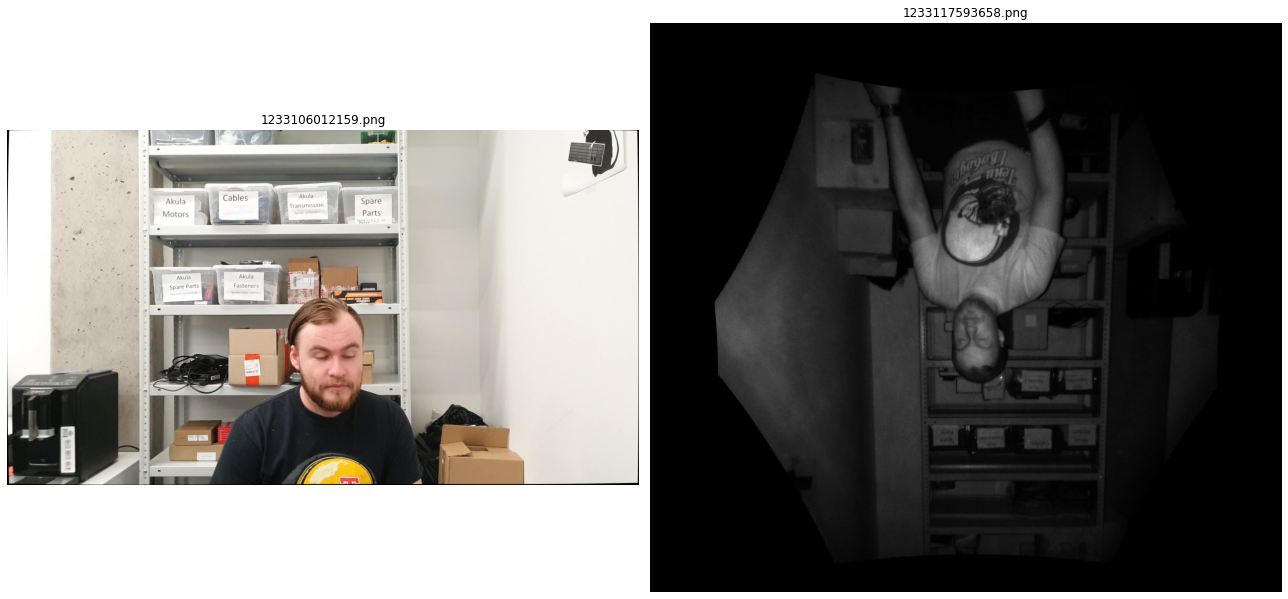

In [26]:
idx = 0

check_s10_key, check_azure_key = s10_timestamps[idx], azure_timestamps[idx]

plot_figures({check_s10_key + img_ext: s10_images[check_s10_key + img_ext], 
              check_azure_key + img_ext: azure_images[check_azure_key + img_ext]}, 1, 2)

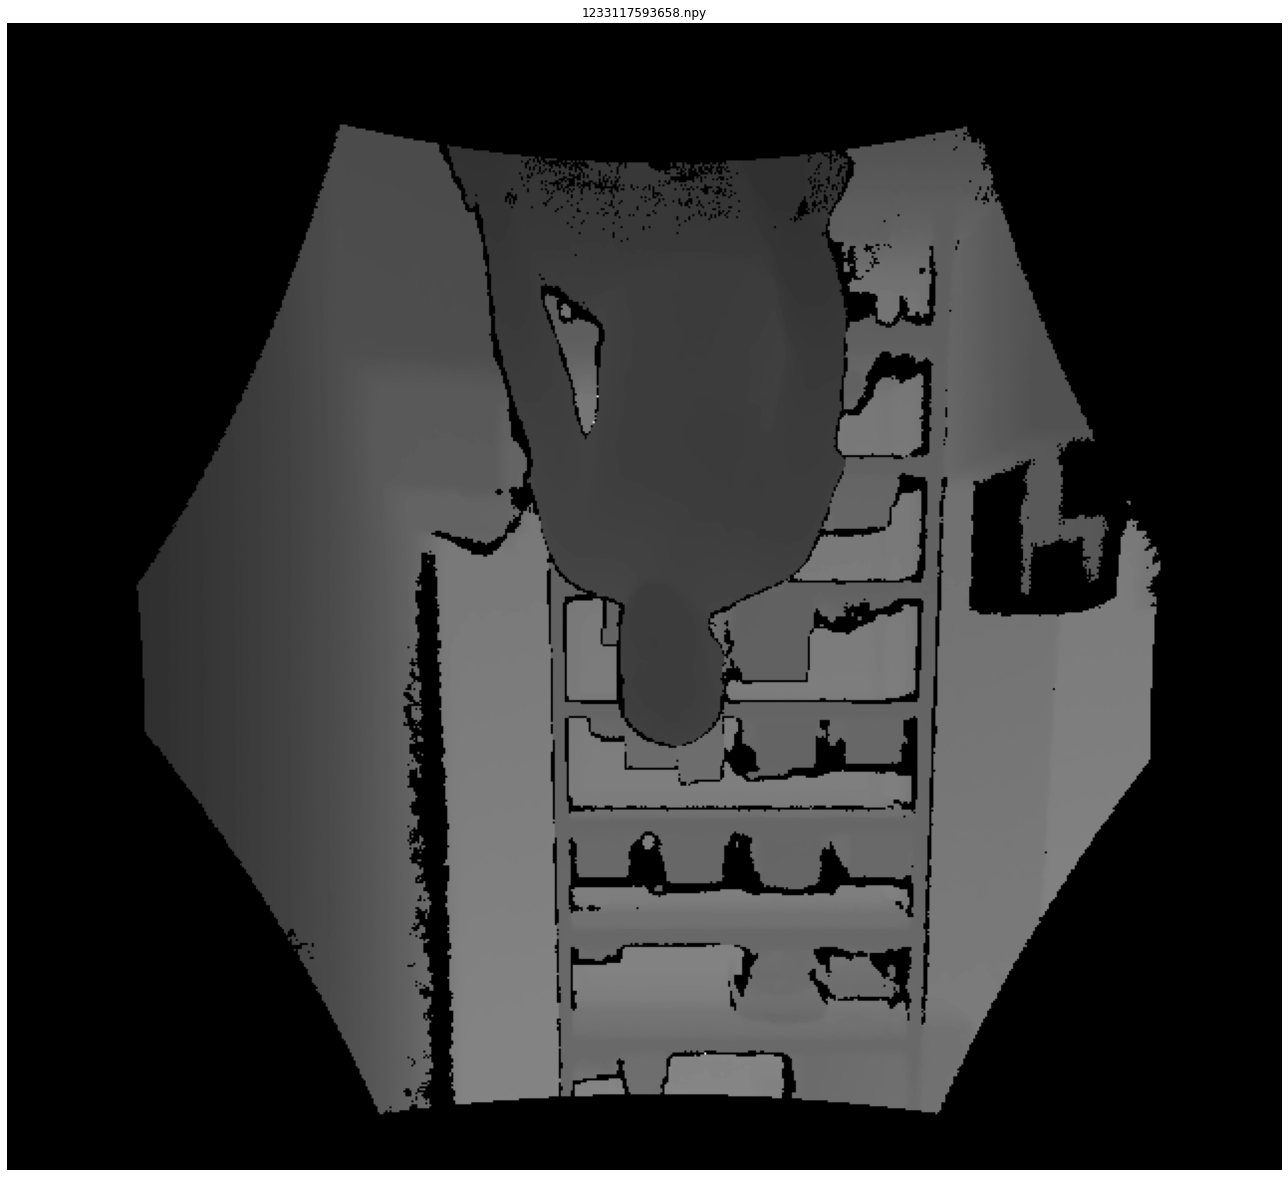

In [27]:
plot_figures({check_azure_key + depth_ext: azure_depths[check_azure_key + depth_ext]})

In [28]:
azure_pcd_depths = pointcloudify_depths(azure_depths, azure_undist_intrinsics)

In [29]:
s10_keys = list(s10_images.keys())
azure_keys = list(azure_pcd_depths.keys())

In [30]:
T_opt = np.load("calib_output/azure2s10_standard_extrinsics.npy")

In [31]:
T_opt

array([[-0.99998813, -0.00486804, -0.00019747,  0.00619728],
       [ 0.00486541, -0.99569084, -0.09260707,  0.10634413],
       [ 0.0002542 , -0.09260693,  0.99570271,  0.05728305],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

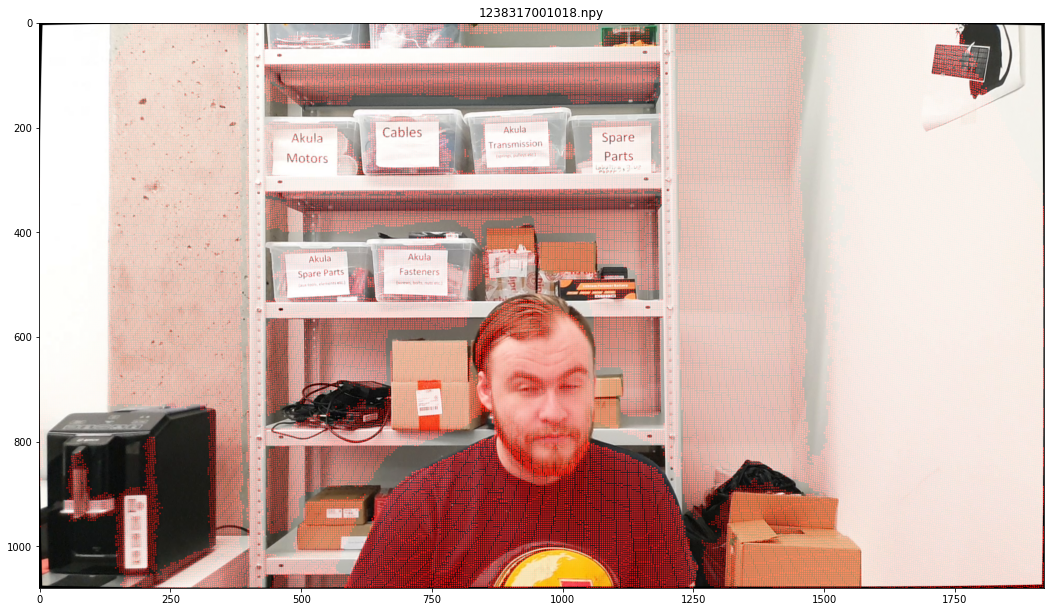

In [42]:
idx = 13

check_azure_pcd = azure_pcd_depths[azure_keys[idx]]
check_azure_pcd = to_cartesian((T_opt @ to_homogeneous(check_azure_pcd).transpose()).transpose())

plot_projected_pcd(s10_images[s10_keys[idx]], check_azure_pcd, s10_undist_intrinsics, azure_keys[idx])